Actor-Critic Rocket
---

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt

In [2]:
target_velocity = [30000., 0.] #m/s
target_altitude = 500000. #m
isp = 500. #s
g = 9.81 #m/s

In [102]:
#create a rocket ready to launch.
class rocket:
    def __init__(self,
                 g = 9.81,
                 dry_mass = 10.,
                 fuel_mass = 1000.,
                 isp = 5000.,
                 torque_strength = 5,
                 time_step = 0.1,
                 drag_coef = 0.1,
                 length = 4,
                 max_fuel_rate = 1 # per second
                ):
        #keep track of flight time
        self.stopwatch = 0.
        self.time_step = time_step
        self.position = np.array([0.,0.])
        
        #current velocity and pointing direction (not necessarily parallel)
        self.velocity =  np.array([0.,0.])
        self.heading = np.array([0.,1.])
        
        #angular velocity
        self.spin = 0.
        
        #drag
        self.drag_coef = drag_coef
        self.area = 1.
        #the rocket is 4x longer than it is wide, with this ratio being the perpendicular drag to head-on drag.
        self.length = length
        
        #fuel, mass, and efficiency
        self.fuel_rate = max_fuel_rate
        self.fuel_mass = fuel_mass
        self.dry_mass = dry_mass
        self.isp = isp
        self.torque_strength = torque_strength
        
        #gravity
        self.g = np.array([0., -g])
        
        #keep track of trajectory history
        self.position_history = [
            self.position
        ]
        self.velocity_history = [
            self.velocity
        ]
        self.heading_history = [
            self.heading
        ]
    
    #calculate drag area due to not flying directly forward
    def drag_area(self):
        speed = np.linalg.norm(self.velocity)
        dot = np.dot(self.velocity, self.heading)
        if speed > 0. and dot != 0.:
            heading_velocity_angle = np.arccos(np.clip(dot/(1.*speed), 0, 1)) #heading is always length 1
            this_area = self.area*(1. + np.sin(heading_velocity_angle))
            return this_area
        else:
            return self.area
        
    #adds speed in heading direction and removes fuel
    def fire(self):
        fuel_chunk = self.fuel_rate*self.time_step
        fuel_velocity = self.isp*np.linalg.norm(self.g)
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        #remove fuel to fire
        self.fuel_mass -= fuel_chunk
        # change in speed is fuel spent this time step times fuel speed over remaining rocket mass
        dv = fuel_chunk * fuel_velocity / (self.fuel_mass + self.dry_mass)
        # add new speed to the velocity in the direction of heading
        self.velocity = self.velocity + self.heading * dv
    
    #adds rot. velocity and removes fuel
    def torque(self, clockwise = False):
        fuel_chunk = self.fuel_rate*self.time_step
        if fuel_chunk >= self.fuel_mass:
            fuel_chunk = self.fuel_mass
        torque_direction = 1
        if clockwise:
            torque_direction = -1
        self.spin += self.torque_strength * fuel_chunk * self.time_step * torque_direction
        self.fuel_mass -= fuel_chunk
        
    def is_crashed(self):
        if self.position[1] < 0:
            return True
        else:
            return False
    
    def advance(self):
        #advance stopwatch
        self.stopwatch = self.stopwatch + self.time_step
        
        #evolve rocket position in direction of velocity
        self.position = self.position + self.velocity*self.time_step
        self.position_history.append(self.position)
        
        #evolve rocket heading according to spin
        rotation_angle = self.spin * self.time_step
        rotation_matrix = np.array(
            [
                [np.cos(rotation_angle),np.sin(rotation_angle)],
                [-np.sin(rotation_angle),np.cos(rotation_angle)]
            ]
        )
        self.heading = self.heading/np.linalg.norm(np.matmul(rotation_matrix , self.heading))
        self.heading_history.append(self.heading)
        
        #evolve rocket velocity in direction of drag + gravity
        drag = 0.5 * self.drag_coef * self.drag_area() * np.linalg.norm(self.velocity) * self.velocity
        self.velocity = self.velocity + self.time_step * (self.g - drag/(self.dry_mass+self.fuel_mass))
        self.velocity_history.append(self.velocity)
        return self.position, self.velocity, self.heading
        
    def plot_trajectory(self):
        x = np.array(self.position_history)[:,0]
        y = np.array(self.position_history)[:,1]
        plt.scatter(x,y)
        plt.show()

In [103]:
seed = 2022
gamma = 0.99
max_simulation_time = 120 #seconds
eps = np.finfo(np.float32).eps.item()

In [104]:
#inputs are the state of the rocket. Six values returned from rocket.advance()
num_inputs = 6
#actions are fire, torque l, torque r, and off
num_actions = 4
num_hidden = 64

inputs = keras.layers.Input(shape = (num_inputs,))
common = keras.layers.Dense(num_hidden, activation = 'relu')(inputs)
action = keras.layers.Dense(num_actions, activation = 'softmax')(common)
critic = keras.layers.Dense(1)(common)

model = keras.Model(inputs = inputs, outputs = [action, critic])

In [105]:
target_velocity = np.array([1000., 0.])
target_altitude = 200000.

#gives a reward value based on the rocket state of position, velocity, heading
def reward(rocket_state, speed = target_velocity[0], altitude = target_altitude):
    return abs(rocket_state[0,2] - speed) + abs(rocket_state[0,1] - altitude)
    

running reward: 1154533.63 at episode 10
running reward: 16852690.97 at episode 20


KeyboardInterrupt: 

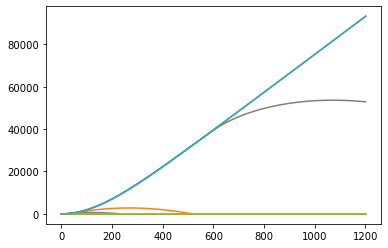

In [106]:


optimizer = tf.optimizers.Adam(learning_rate = 0.01)
huber = tf.losses.Huber()
action_probs_history = []
critic_value_history = []
rewards_history = []
running_reward = 0
episode_count = 0


rng = np.random.default_rng(seed)


num_episodes = 120
episode_update_period = 10

for epoch in range(num_episodes):
    rkt = rocket()
    state = tf.convert_to_tensor([rkt.position, rkt.velocity, rkt.heading])
    state = tf.reshape(state, (1,6,))
    
    episode_reward = 0
    
    with tf.GradientTape() as tape:
        while not rkt.is_crashed() and rkt.stopwatch <= max_simulation_time:
                
            action_probs, critic_value = model(state)
            critic_value_history.append(critic_value[0,0])

            action = rng.choice(num_actions, p = np.squeeze(action_probs))
            action_probs_history.append(tf.math.log(action_probs[0, action]))

            if action == 0:
                rkt.fire()
            elif action == 1:
                rkt.torque()
            elif action == 2:
                rkt.torque(clockwise=True)
            elif action == 3:
                pass
            else:
                print('something went wrong in assigning an action.')

            state = rkt.advance()
            state = tf.reshape(state, (1,6,))
            
            this_reward = reward(state)
            
            rewards_history.append(this_reward)
            episode_reward += this_reward
        
        running_reward = 0.05 * episode_reward + (1-0.05) * running_reward
        
        returns = []
        discounted_sum = 0
        for r in rewards_history[::-1]:
            discounted_sum = r + gamma*discounted_sum
            returns.insert(0, discounted_sum)
        returns = np.array(returns)
        returns = (returns - np.mean(returns)) / (np.std(returns) + eps)
        returns = returns.tolist()
        
        history = zip(action_probs_history, critic_value_history, returns)
        actor_losses = []
        critic_losses = []
        for log_prob, value, ret in history:
            diff = ret - value
            actor_losses.append(-log_prob*diff)
            critic_losses.append(
                huber(tf.expand_dims(value, 0), tf.expand_dims(ret,0))
            )
        loss_value = sum(actor_losses) + sum(critic_losses)
        grads = tape.gradient(loss_value, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
        
        action_probs_history.clear()
        critic_value_history.clear()
        rewards_history.clear()
        
    episode_count += 1
    if episode_count % episode_update_period == 0:
        template = 'running reward: {:.2f} at episode {}'
        print(template.format(running_reward, episode_count))
        
    plt.plot(np.array(rkt.position_history))

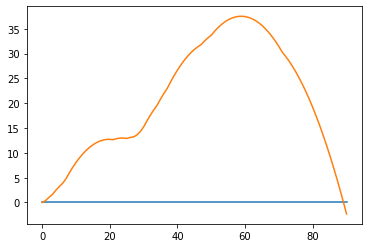

In [77]:
plt.plot(np.array(rkt.position_history))